<a href="https://colab.research.google.com/github/souhityac/LSTM-based-NSE-Stock-Predictions/blob/main/LSTM_NSE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing investpy

!pip install investpy

In [ ]:
# Data Collection 
# HDFC Bank data - January,2016 to Oct,2020
# Timeframe - Daily

import investpy

df = investpy.get_stock_historical_data(stock='HDBK',
                                        country='India',
                                        from_date='01/01/2016',
                                        to_date='08/10/2020')


In [ ]:
# Size of dataset 

df.shape

(1180, 6)

In [ ]:
# Creating a dataframe of the downloaded data

import pandas as pd

df = pd.DataFrame(df)

In [ ]:
df

In [ ]:
# Dropping currency and volume columns 

df = df.drop(['Currency'],axis=1)

In [ ]:
df

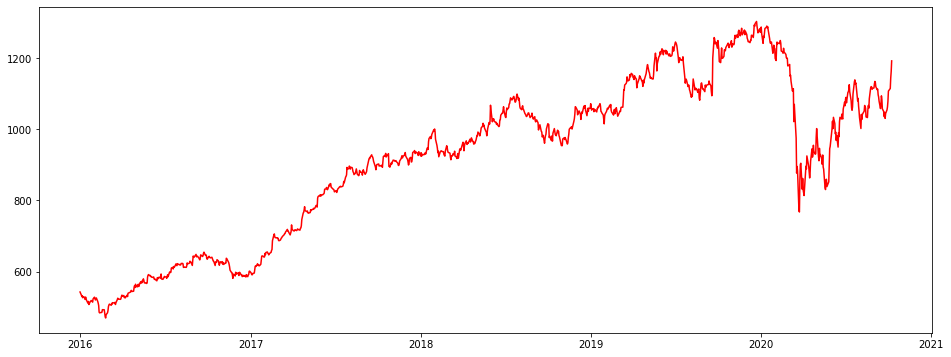

In [ ]:
# Plotting the data

import matplotlib.pyplot as plt

plt.figure(1,figsize=(16,6))
_ = plt.plot(df.Close, color='red')

In [ ]:
# Dropping null values

df.dropna(inplace=True)

# Feature Set of OHLC

X = df.values

In [ ]:
# Preprocessing the data 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
X_scaled = scaler.transform(X)

In [ ]:
# Creating the labels

Y = [x[3] for x in X_scaled]

In [ ]:
# Train-Test Split

split= int(len(X_scaled)*0.70)
x_train = X_scaled[:split]
x_test = X_scaled[split: len(X_scaled)]
y_train = Y[:split]
y_test = Y[split: len(Y)]

In [ ]:
# Shape of train-test data, used to determining batch size

print(x_train.shape)
print(x_test.shape)

(826, 5)
(354, 5)


In [ ]:
# Creating window data: input for time-series model
# Using 2 trading weeks of data as input to predict the next timestep

timestep = 10
xtrain,ytrain,xtest,ytest = [],[],[],[]

for i in range(timestep, len(x_train)):
  xtrain.append(x_train[i-timestep:i, :x_train.shape[1]])
  ytrain.append(y_train[i])

for i in range(timestep, len(x_test)):
  xtest.append(x_test[i-timestep:i, :x_test.shape[1]])
  ytest.append(y_test[i])

In [ ]:
# Converting window data into arrays to pass as input to the model

import numpy as np 
xtrain,ytrain = (np.array(xtrain),np.array(ytrain))
xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))

xtest,ytest = (np.array(xtest),np.array(ytest))
xtest = np.reshape(xtest, (xtest.shape[0],xtest.shape[1],xtest.shape[2]))

In [ ]:
# Batch size calculator

import math
math.gcd(xtrain.shape[0],xtest.shape[0])

8

In [ ]:
import time
import warnings
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

In [ ]:
# LSTM Model with 32-32-16 architecture

model = Sequential()

model.add(LSTM(units=32,batch_size=8,input_shape = (10,5),stateful=True,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32,stateful=True,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=16,stateful=True,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (8, 10, 32)               4864      
_________________________________________________________________
dropout_12 (Dropout)         (8, 10, 32)               0         
_________________________________________________________________
lstm_13 (LSTM)               (8, 10, 32)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (8, 10, 32)               0         
_________________________________________________________________
lstm_14 (LSTM)               (8, 16)                   3136      
_________________________________________________________________
dropout_14 (Dropout)         (8, 16)                   0         
_________________________________________________________________
dense_4 (Dense)              (8, 1)                   

In [ ]:
# Training the model
# Loss metric: Mean Squared Error

model.fit(xtrain,ytrain,epochs=500,validation_data=(xtest,ytest), batch_size=8,verbose=1)

NameError: ignored

In [ ]:
# Testing the model 

testpredict = model.predict(xtest, batch_size=8)

NameError: ignored

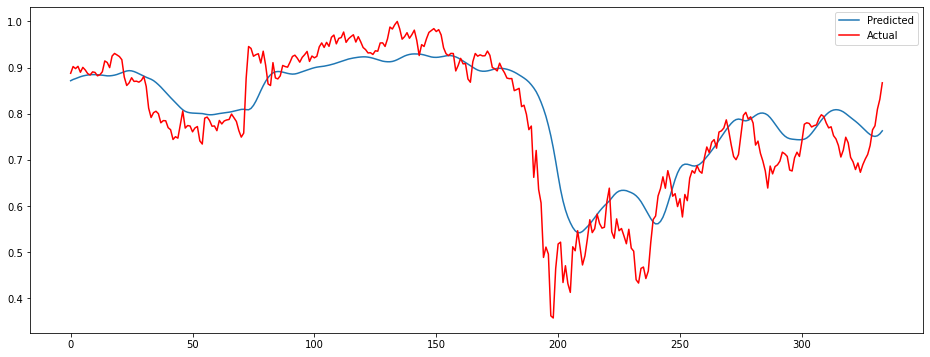

In [ ]:
# Plotting the results

plt.figure(2,figsize=(16,6))
_ = plt.plot(testpredict,label='Predicted')
t = plt.plot(ytest,label='Actual',color='red')
plt.legend()